# Drug dataset - Sentiment Analysis 

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay, plot_roc_curve
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/odelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/odelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/odelia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', encoding="UTF-8", index_col=[0])
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', encoding="UTF-8", index_col=[0])

## Preliminary data exploration

In [4]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [5]:
# Merge train and test sets

In [6]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [7]:
df

,drugName,condition,review,rating,date,usefulCount,length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,17
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
...,...,...,...,...,...,...,...
215058,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43,97
215059,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11,130
215060,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7,149
215061,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20,34


In [8]:
df = df.drop_duplicates(subset=["condition" ,"review", "rating"]).reset_index(drop=True)

In [9]:
df.drugName.value_counts()

Levonorgestrel                       2533
Etonogestrel                         2245
Ethinyl estradiol / norethindrone    1945
Phentermine                          1813
Ethinyl estradiol / norgestimate     1519
                                     ... 
Motofen                                 1
Dextrostat                              1
Oxymetholone                            1
Locoid Lipocream                        1
Fluorometholone                         1
Name: drugName, Length: 3199, dtype: int64

In [10]:
df.condition.value_counts()

Birth Control                                   19524
Depression                                       7113
Pain                                             5193
Anxiety                                          5091
Acne                                             4551
                                                ...  
Somatoform Pain Disorde                             1
Esophageal Spasm                                    1
Campylobacter Gastroenteritis                       1
Peyronie's Disease                                  1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [11]:
# No duplication
df.describe()

,rating,usefulCount,length
count,130285.000000,130285.000000,130285.000000
mean,6.997582,26.924059,84.258242
std,3.274199,35.135337,44.962225
min,1.000000,0.000000,1.000000
25%,5.000000,6.000000,48.000000
50%,8.000000,15.000000,84.000000
75%,10.000000,35.000000,126.000000
max,10.000000,1291.000000,1894.000000


In [221]:
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,1
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,1
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,1
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130285 entries, 0 to 130284
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     130285 non-null  object
 1   condition    129091 non-null  object
 2   review       130285 non-null  object
 3   rating       130285 non-null  int64 
 4   date         130285 non-null  object
 5   usefulCount  130285 non-null  int64 
 6   length       130285 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.0+ MB


In [15]:
df.isnull().any()

drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [16]:
sum(df.condition.isnull())

1194

### 'Rating' column

<AxesSubplot:xlabel='rating', ylabel='count'>

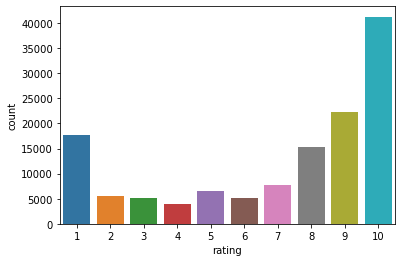

In [17]:
sns.countplot(df['rating'])

In [18]:
# data is skewed, imalanced towards positive ratings

In [19]:
df.rating.value_counts(normalize=True)

10    0.316744
9     0.170595
1     0.135303
8     0.117182
7     0.058902
5     0.049729
2     0.042146
3     0.039567
6     0.039375
4     0.030456
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

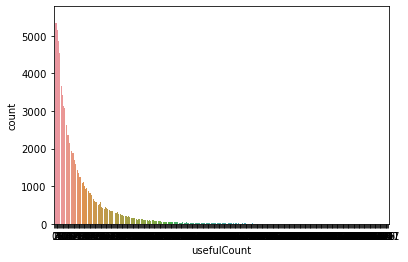

In [20]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

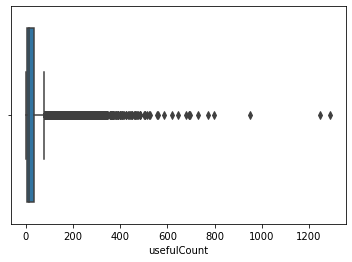

In [21]:
sns.boxplot(x=df['usefulCount'])

In [22]:
df['usefulCount'].describe()

count    130285.000000
mean         26.924059
std          35.135337
min           0.000000
25%           6.000000
50%          15.000000
75%          35.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [23]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

5510

In [24]:
df.usefulCount.value_counts()

0      5510
3      5340
2      5332
1      5251
4      5156
       ... 
357       1
331       1
307       1
301       1
324       1
Name: usefulCount, Length: 397, dtype: int64

In [25]:
df

,drugName,condition,review,rating,date,usefulCount,length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,17
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,141
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,134
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,89
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,124
...,...,...,...,...,...,...,...
130280,Methadone,Pain,"""Have been taking it for 6 years (120 milligra...",10,"August 2, 2011",16,12
130281,Clomipramine,Panic Disorde,"""I&#039;ve been on clomipramine 15 years now a...",10,"February 19, 2013",28,49
130282,Levetiracetam,Epilepsy,"""I now suffer from excessive tiredness and lac...",8,"July 21, 2016",5,20
130283,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,"September 13, 2014",43,97


### >>>>>>> Review DUP

In [26]:
uc = df.usefulCount.value_counts().reset_index().rename(columns={"index": "values_c"}) 

In [27]:
top5l = list(uc.sort_values(by="values_c",  ascending=False).reset_index(drop=True).iloc[0:5].values_c.values)

In [28]:
df.query("usefulCount in @top5l")

,drugName,condition,review,rating,date,usefulCount,length
2030,Citalopram,Depression,"""I responded after one week. The side effects ...",8,"March 25, 2008",771,82
4210,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,"April 1, 2009",1247,114
6611,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,"July 31, 2008",1291,187
16346,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,"October 19, 2008",796,142
106826,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,"August 5, 2008",949,53


In [29]:
df.loc[df.usefulCount == df.usefulCount.max(), 'review']

6611    "I remember reading people&#039;s opinions, on...
Name: review, dtype: object

In [30]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

### General trends in the data

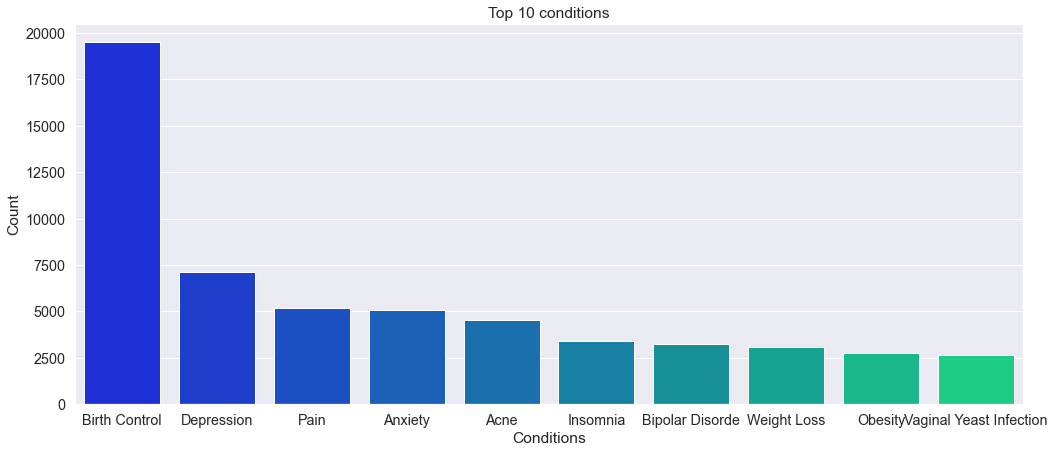

In [31]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

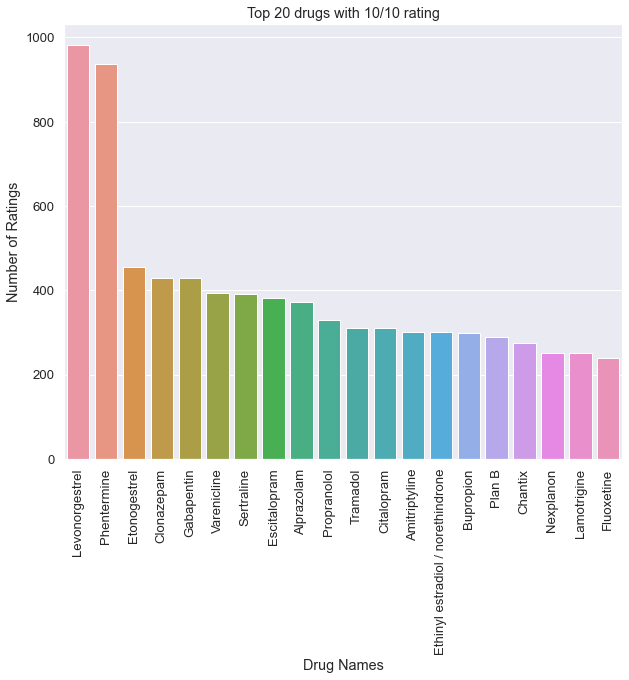

In [32]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

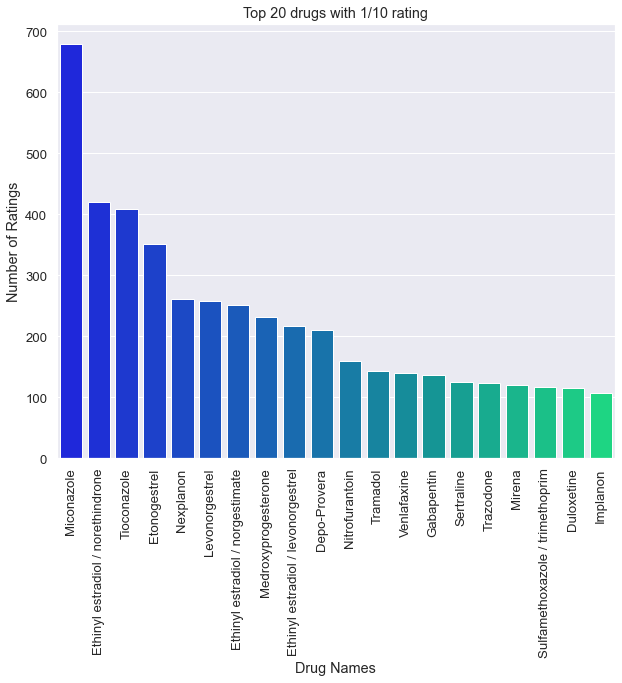

In [33]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

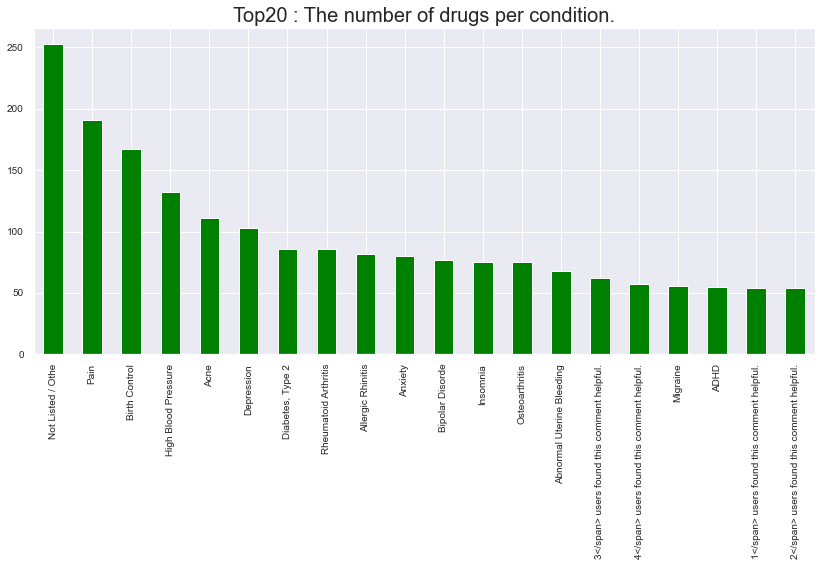

In [34]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [35]:
df.drugName.nunique()

3199

In [36]:
# Most useful reviews

In [38]:
"df.loc(review[max]"

'df.loc(review[max]'

## Data Cleaning

### Clean 'condition' column

In [39]:
df["condition_clean"] = df.condition.apply(lambda x: "unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [40]:
df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

1171

In [41]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [42]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [43]:
df["condition_clean"].nunique()

837

In [44]:
#df = df.dropna()
df
# -1194 records
df.condition.fillna("unknown", axis=0, inplace=True)

### Clean reviews (inplace)

In [47]:
df.drop(["date", "condition"], axis=1, inplace=True)

In [48]:
df["review"] = df.review.str.replace("&#039;", "")
#df

In [49]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [50]:
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...
130280,Methadone,"""have been taking it for 6 years (120 milligra...",10,16,12,Pain
130281,Clomipramine,"""ive been on clomipramine 15 years now and bas...",10,28,49,Panic Disorde
130282,Levetiracetam,"""i now suffer from excessive tiredness and lac...",8,5,20,Epilepsy
130283,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",10,43,97,"Breast Cancer, Prevention"


In [51]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,9
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,8
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,5
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,9
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,10
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,10
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,8
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,10


In [52]:
df.to_excel("drugs_cond_cln_plus_reviews.xlsx")

IllegalCharacterError: 

In [54]:
df.loc[df_clean["length"] == max(df["length"]), "length"]
#df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

65002    1894
Name: length, dtype: int64

In [55]:
#df.review.iat[75663]

In [56]:
df_clean_for_reg = df_clean.drop(["review"], axis=1)
df_clean_for_reg

,drugName,condition_clean,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,27,17,9
1,Guanfacine,ADHD,192,141,8
2,Lybrel,Birth Control,17,134,5
3,Ortho Evra,Birth Control,10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,37,124,9
...,...,...,...,...,...
130280,Methadone,Pain,16,12,10
130281,Clomipramine,Panic Disorde,28,49,10
130282,Levetiracetam,Epilepsy,5,20,8
130283,Tamoxifen,"Breast Cancer, Prevention",43,97,10


In [57]:
df_clean_for_reg.to_csv("drugs_df_for_lin_reg.csv")

### Feature engineering: 'rating'

In [58]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",1,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",1,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",0,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",1,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",1,37,124,Opiate Dependence
...,...,...,...,...,...,...
130280,Methadone,"""have been taking it for 6 years (120 milligra...",1,16,12,Pain
130281,Clomipramine,"""ive been on clomipramine 15 years now and bas...",1,28,49,Panic Disorde
130282,Levetiracetam,"""i now suffer from excessive tiredness and lac...",1,5,20,Epilepsy
130283,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",1,43,97,"Breast Cancer, Prevention"


In [59]:
df['rating'].value_counts()

1    86434
0    43851
Name: rating, dtype: int64

In [60]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df = df.reindex(columns=column_names)
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,1
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,1
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,1
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1


## Creating the Corpus

In [61]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [62]:
len(corpus)

130285

In [63]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [64]:
len(corpus)

753513

### Cleaning corpus

In [65]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [66]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [67]:
# Tokenizing the corpus

In [68]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [69]:
len(list(wordfreq.keys()))

49773

In [70]:
wordfreq

{'it': 229415,
 'has': 38771,
 'no': 47360,
 'side': 42947,
 'effect': 8976,
 'i': 599027,
 'take': 36678,
 'in': 102644,
 'combination': 1357,
 'of': 138723,
 'bystolic': 176,
 'mg': 40053,
 'and': 347025,
 'fish': 135,
 'oil': 571,
 'my': 232957,
 'son': 1746,
 'is': 90229,
 'halfway': 143,
 'through': 7713,
 'his': 2496,
 'fourth': 481,
 'week': 22548,
 'intuniv': 141,
 'we': 5803,
 'became': 3483,
 'concerned': 751,
 'when': 29478,
 'he': 10939,
 'began': 4084,
 'this': 110705,
 'last': 12762,
 'started': 34109,
 'taking': 42381,
 'the': 326456,
 'highest': 283,
 'dose': 13028,
 'will': 21642,
 'be': 32380,
 'on': 108769,
 'for': 162154,
 'two': 17073,
 'days': 32834,
 'could': 12010,
 'hardly': 1075,
 'get': 32924,
 'out': 30585,
 'bed': 5269,
 'was': 140961,
 'very': 31625,
 'cranky': 133,
 'slept': 1583,
 'nearly': 1916,
 'hours': 13517,
 'a': 233272,
 'drive': 5193,
 'home': 2647,
 'from': 31203,
 'school': 2398,
 'vacation': 225,
 'unusual': 344,
 'him': 2372,
 'called': 1947,

### Reducing the corpus

#### Stopwords

In [71]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [72]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [ ]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])

In [74]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering'),
 (6115, 'thing

In [75]:
corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

In [76]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

#### LIST 1 [FULL]

In [77]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

Index(['side', 'taking', 'pain', 'year', 'take', 'effect', 'first', 'started',
       'like', 'month', 'get', 'day', 'time', 'feel', 'would', 'back', 'one',
       'week', 'pill', 'medication', 'took', 'also', 'doctor', 'weight', 'got',
       'life', 'anxiety', 'dont'],
      dtype='object')

In [78]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [79]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'pain': 0,
  'year': 0,
  'take': 1,
  'effect': 1,
  'first': 0,
  'started': 0,
  'like': 0,
  'month': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 0,
  'pill': 0,
  'medication': 0,
  'took': 0,
  'also': 0,
  'doctor': 0,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0},
 {'side': 0,
  'taking': 1,
  'pain': 0,
  'year': 0,
  'take': 0,
  'effect': 0,
  'first': 0,
  'started': 1,
  'like': 0,
  'month': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 2,
  'pill': 0,
  'medication': 1,
  'took': 0,
  'also': 0,
  'doctor': 1,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0}]

In [80]:
reviews = pd.DataFrame(my_list)

In [81]:
reviews

,side,taking,pain,year,take,effect,first,started,like,month,...,pill,medication,took,also,doctor,weight,got,life,anxiety,dont
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,3,1,0,0,1,2,1,1,0,0,...,2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,3,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130280,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130281,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
130282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130283,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [82]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

,side,taking,pain,year,take,effect,first,started,like,month,...,medication,took,also,doctor,weight,got,life,anxiety,dont,rating
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,3,1,0,0,1,2,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,3,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130280,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130281,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
130282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130283,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


#### LIST 3: stopwords incl. negation

In [83]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
new_stop_words = stop_words.difference(exclude_words)

In [84]:
new_stop_words = list(new_stop_words)

In [85]:
new_stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])

In [86]:
for i in range(len(new_stop_words)):
    new_stop_words[i] = re.sub(r"\s*'\s*\w*","",new_stop_words[i])
new_stop_words

['ourselves',
 'other',
 'an',
 'both',
 'on',
 'those',
 'him',
 'be',
 'then',
 'that',
 'mightn',
 'yours',
 'our',
 'shouldn',
 'there',
 'before',
 'should',
 'aren',
 'we',
 'needn',
 'shan',
 'from',
 'being',
 'was',
 'it',
 'should',
 'how',
 'above',
 'to',
 'is',
 'just',
 'of',
 'their',
 's',
 'so',
 'any',
 'or',
 'won',
 'when',
 'into',
 'have',
 'myself',
 'yourself',
 'doesn',
 'ma',
 'a',
 'herself',
 'you',
 'won',
 'during',
 'her',
 'further',
 'ours',
 't',
 'its',
 'does',
 'very',
 'whom',
 'he',
 'for',
 'under',
 'am',
 'has',
 'had',
 'you',
 'than',
 'she',
 'd',
 'itself',
 'them',
 'down',
 'all',
 'weren',
 'more',
 'your',
 'are',
 'after',
 'such',
 'll',
 'some',
 'over',
 'o',
 'you',
 'at',
 'up',
 'she',
 'they',
 'ain',
 'if',
 'you',
 've',
 'that',
 'having',
 'and',
 'm',
 'the',
 'too',
 'these',
 'against',
 'this',
 'which',
 'but',
 'me',
 'same',
 'where',
 'you',
 'hadn',
 'while',
 'wasn',
 'through',
 'wouldn',
 'once',
 'most',
 'who',

In [87]:
corpus4 = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in new_stop_words]
corpus4

[(47360, 'no'),
 (42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering')

In [88]:
corpus4.sort(reverse = True)
corpus_freq4 = [(word[1],word[0]) for word in corpus4[:31]] 
corpus_freq4 = corpus_freq4[1:]
corpus_freq4

[('day', 48525),
 ('no', 47360),
 ('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369)]

In [89]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [90]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
130280    1
130281    1
130282    1
130283    1
130284    1
Name: rating, Length: 130285, dtype: int64

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [92]:
X_train
y_train

,rating
28970,1
100957,1
108596,0
5119,0
98525,1
...,...
128106,0
103694,1
860,1
15795,0


In [93]:
y_test.value_counts()

rating
1         17232
0          8825
dtype: int64

In [94]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

### Making predictions with RF

In [95]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [96]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [97]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     35026
           1       0.90      0.98      0.94     69202

    accuracy                           0.92    104228
   macro avg       0.92      0.89      0.90    104228
weighted avg       0.92      0.92      0.91    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.12
              precision    recall  f1-score   support

           0       0.49      0.23      0.32      8825
           1       0.69      0.87      0.77     17232

    accuracy                           0.66     26057
   macro avg       0.59      0.55      0.54     26057
weighted avg       0.62      0.66      0.62     26057



#### Tuning the hyper paramters with gridsearch

In [98]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [99]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

## grid_search.fit(X_train,y_train)

In [101]:
grid_search.fit(X_train,y_train)

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [102]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 50}

In [103]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=50, min_samples_leaf =1 ,random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6719595502168323
0.6635836819280807


In [ ]:
# What does that mean?

In [104]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.601077,0.022131,0.086862,0.005947,True,5,sqrt,1,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.663948,0.000018,49,0.663944,0.663944,0.663956,0.663948,0.663948,0.663948,0.000004
1,3.060327,0.091600,0.141976,0.002740,True,5,sqrt,1,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.663948,0.000018,49,0.663944,0.663944,0.663956,0.663948,0.663948,0.663948,0.000004
2,14.864110,0.141461,0.778385,0.023074,True,5,sqrt,1,500,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.663948,0.000018,49,0.663944,0.663944,0.663956,0.663948,0.663948,0.663948,0.000004
3,1.488658,0.006398,0.074713,0.004971,True,5,sqrt,2,50,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.663948,0.000018,49,0.663944,0.663944,0.663956,0.663948,0.663948,0.663948,0.000004
4,3.000716,0.057897,0.149168,0.010341,True,5,sqrt,2,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",...,0.663948,0.000018,49,0.663944,0.663944,0.663956,0.663948,0.663948,0.663948,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,5.017536,0.063577,0.223762,0.003648,False,10,log2,1,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.664668,0.000088,20,0.669401,0.670612,0.670696,0.670137,0.670508,0.670271,0.000475
68,25.046139,0.079821,1.104572,0.055555,False,10,log2,1,500,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.664620,0.000063,23,0.669293,0.670444,0.670756,0.670125,0.670245,0.670173,0.000489
69,2.533762,0.031234,0.116162,0.004277,False,10,log2,2,50,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.664725,0.000139,18,0.668358,0.670325,0.669989,0.669585,0.670077,0.669666,0.000696
70,5.012575,0.059844,0.222054,0.008413,False,10,log2,2,100,"{'bootstrap': False, 'max_depth': 10, 'max_fea...",...,0.664687,0.000046,19,0.668190,0.669761,0.669725,0.669249,0.669573,0.669300,0.000584


In [105]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.6597267516502527


#### Running the Naive Bayes model

In [106]:
#y_train
#X_train

In [107]:
#nb = CategoricalNB()
#nb.fit(X_train, y_train['rating'])

(Not) Making predictions with NB

In [108]:
#y_train_pred_nb = nb.predict(X_train)
#y_test_pred_nb  = nb.predict(X_test)

Model performance

In [109]:
#model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

### SVC instead of NB

In [110]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42, tol=1e-2, max_iter=5000)

In [111]:
svm.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=42, tol=0.01)

In [112]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [113]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.50      0.04      0.07     35026
           1       0.67      0.98      0.79     69202

    accuracy                           0.66    104228
   macro avg       0.59      0.51      0.43    104228
weighted avg       0.61      0.66      0.55    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.02
              precision    recall  f1-score   support

           0       0.47      0.04      0.07      8825
           1       0.66      0.98      0.79     17232

    accuracy                           0.66     26057
   macro avg       0.57      0.51      0.43     26057
weighted avg       0.60      0.66      0.55     26057



In [114]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [115]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [116]:
reviews_cleaned = df.copy()

In [117]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [118]:
reviews_cleaned.head()

,review,rating
0,"""it has no side effect, i take it in combinati...",1
1,"""my son is halfway through his fourth week of ...",1
2,"""i used to take another oral contraceptive, wh...",0
3,"""this is my first time using any form of birth...",1
4,"""suboxone has completely turned my life around...",1


In [119]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [120]:
reviews_cleaned.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


### >>> Running the TF-IDF model 

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [122]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [123]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilify mg',
 'abilities',
 'ability',
 'ability focus',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able deal',
 'able drink',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able quit',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able things',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely hate',
 'ab

In [124]:
len(tidf.get_feature_names())

20000

In [125]:
X_TF[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [126]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [127]:
type(X_TF_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [128]:
rf1 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf1.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf1.predict(X_TF_train)
y_TF_test_pred_rf  = rf1.predict(X_TF_test)

#### Model performance

In [129]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     35026
           1       0.99      1.00      1.00     69202

    accuracy                           0.99    104228
   macro avg       1.00      0.99      0.99    104228
weighted avg       0.99      0.99      0.99    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.46
              precision    recall  f1-score   support

           0       0.82      0.46      0.59      8825
           1       0.78      0.95      0.85     17232

    accuracy                           0.78     26057
   macro avg       0.80      0.71      0.72     26057
weighted avg       0.79      0.78      0.76     26057



,Error_metric,Train,Test
0,Accuracy,0.994032,0.784127
1,Precision,0.991162,0.775191
2,Recall,0.999928,0.948700


Confusion matrix for the train set
[[34409     5]
 [  617 69197]]


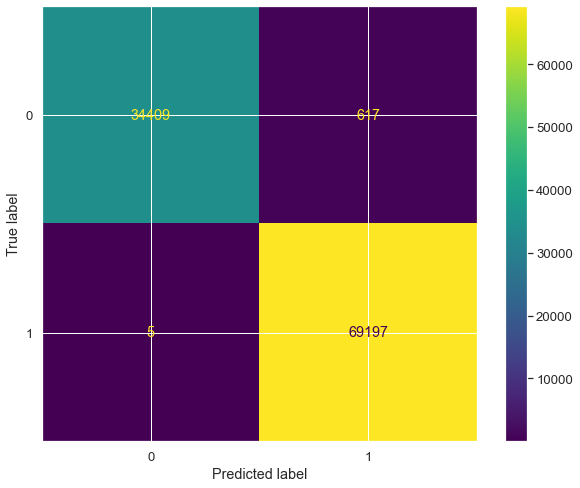



Confusion matrix for the test set
[[ 4084   884]
 [ 4741 16348]]


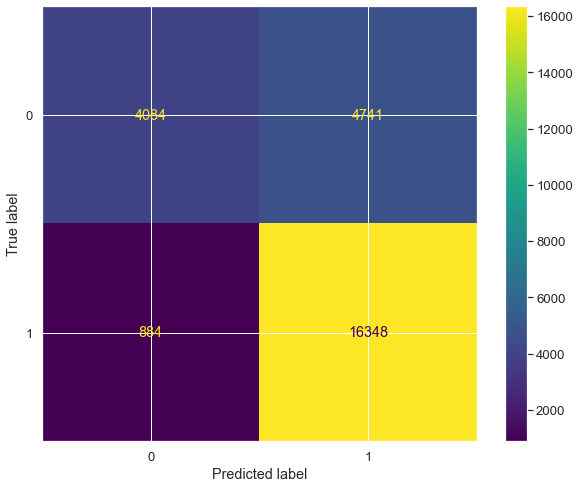

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                         precision_score(y_TF_train, y_TF_train_pred_rf),
                                         recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})

display(performance_df)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train,y_TF_train_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_train, y_TF_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test,y_TF_test_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_test,y_TF_test, values_format = 'd')
plt.show()

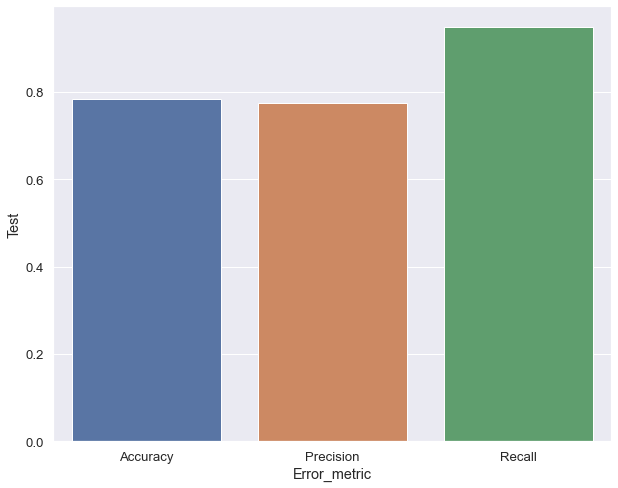

In [131]:
ax = sns.barplot(x="Error_metric", y="Test", data=performance_df)

## LIST 1: POS tagging ins. of stopwords

### Applying tags and filtering POS

In [133]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Tokenizing

In [134]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [135]:
list_filtered = filter_review(str(corpus_pre_tok))

In [136]:
len(list_filtered)

3110618

### Reducing the list

In [137]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [138]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('im', 44652),
 ('side', 42947),
 ('taking', 42381),
 ('mg', 40053),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('ive', 36646),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669)]

In [139]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE

In [140]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

,review,rating
2,i used to take another oral contraceptive whic...,0
5,nd day on mg started to work with rock hard e...,0
6,he pulled out but he cummed a bit in me i took...,0
8,i ve had nothing but problems with the keppera...,0
12,i had crohns with a resection years ago and ...,0
...,...,...
130260,started using lisinopril stopping water pill d...,0
130261,i split the tablets into portions and i slee...,0
130262,after sucessfully taking avinza x daily i w...,0
130271,i started burning and itching after taking a a...,0


In [141]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

(43851, 2)
(43851, 2)


In [142]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down 

,review,rating
48638,i had synvisc one injections about three weeks...,1
26155,i had paragard first inserted in my late s af...,1
118119,i have suffered with psoriasis for years and...,0
65751,i got the implant on may th of at first it ...,1
111910,tried every antidepressant almost but these ha...,1
...,...,...
17051,first time using this prep and it does work mu...,1
115816,i have been on depo for about years and am n...,1
21122,i have had a problem with underarm sweat for y...,1
84434,i was prescribed loryna last summer and it cle...,0


### Re-running models with downsample

In [143]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

[['i had synvisc one injections about three weeks ago in both knees a few years ago i also has the injections over   weeks with no serious pain or after effects but lots of relief for   months at least this time with just one injection my experience was horrendously painful during and after for   hours i had to be taken to my car in a wheel chair after the injections due to pain and swelling ice did help i wish he would have numbed the area  st i think that would have helped for     weeks after the synvisc one injections i had pretty significant ankle and foot swelling that im sure were from the injections i am beginning to feel improvement now again i think i might opt for the   injections next time less pain'],
 ['i had paragard first inserted in my late  s after having my son   years ago   i went and had it removed recently and had another one inserted   since its a very effective birth control the first time it didnt hurt much this time though the cramping and back ache is excrucia

In [144]:
len(corpus2)

87702

In [145]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

['i had synvisc one injections about three weeks ago in both knees a few years ago i also has the injections over   weeks with no serious pain or after effects but lots of relief for   months at least this time with just one injection my experience was horrendously painful during and after for   hours i had to be taken to my car in a wheel chair after the injections due to pain and swelling ice did help i wish he would have numbed the area  st i think that would have helped for     weeks after the synvisc one injections i had pretty significant ankle and foot swelling that im sure were from the injections i am beginning to feel improvement now again i think i might opt for the   injections next time less pain',
 'i had paragard first inserted in my late  s after having my son   years ago   i went and had it removed recently and had another one inserted   since its a very effective birth control the first time it didnt hurt much this time though the cramping and back ache is excruciatin

In [146]:
len(corpus2)

87701

### Cleaning corpus

In [147]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

['i had synvisc one injections about three weeks ago in both knees a few years ago i also has the injections over weeks with no serious pain or after effects but lots of relief for months at least this time with just one injection my experience was horrendously painful during and after for hours i had to be taken to my car in a wheel chair after the injections due to pain and swelling ice did help i wish he would have numbed the area st i think that would have helped for weeks after the synvisc one injections i had pretty significant ankle and foot swelling that im sure were from the injections i am beginning to feel improvement now again i think i might opt for the injections next time less pain',
 'i had paragard first inserted in my late s after having my son years ago i went and had it removed recently and had another one inserted since its a very effective birth control the first time it didnt hurt much this time though the cramping and back ache is excruciating it hurt a little w

In [148]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

['i had synvisc one injections about three weeks ago in both knees a few years ago i also has the injections over weeks with no serious pain or after effects but lots of relief for months at least this time with just one injection my experience was horrendously painful during and after for hours i had to be taken to my car in a wheel chair after the injections due to pain and swelling ice did help i wish he would have numbed the area st i think that would have helped for weeks after the synvisc one injections i had pretty significant ankle and foot swelling that im sure were from the injections i am beginning to feel improvement now again i think i might opt for the injections next time less pain',
 'i had paragard first inserted in my late s after having my son years ago i went and had it removed recently and had another one inserted since its a very effective birth control the first time it didnt hurt much this time though the cramping and back ache is excruciating it hurt a little w

In [149]:
# Tokenizing the corpus

In [150]:
wordfreq2 = {}
for sentence in corpus2:
    words2 = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words2:
        if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
            wordfreq2[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq2[word] += 1 # We increase the corresponding counter

In [151]:
len(list(wordfreq2.keys()))

41220

In [152]:
wordfreq2

{'i': 400917,
 'had': 61806,
 'synvisc': 68,
 'one': 16128,
 'injections': 857,
 'about': 28740,
 'three': 4826,
 'weeks': 16082,
 'ago': 9369,
 'in': 68988,
 'both': 2554,
 'knees': 600,
 'a': 152794,
 'few': 9769,
 'years': 22982,
 'also': 15422,
 'has': 24496,
 'the': 220917,
 'over': 12258,
 'with': 55648,
 'no': 30554,
 'serious': 1060,
 'pain': 25898,
 'or': 19950,
 'after': 34114,
 'effects': 23572,
 'but': 65268,
 'lots': 1137,
 'of': 92954,
 'relief': 3678,
 'for': 107580,
 'months': 22903,
 'at': 34728,
 'least': 2564,
 'this': 77833,
 'time': 20915,
 'just': 21583,
 'injection': 1419,
 'my': 157492,
 'experience': 6296,
 'was': 96548,
 'horrendously': 13,
 'painful': 3642,
 'during': 4442,
 'and': 232700,
 'hours': 9173,
 'to': 175883,
 'be': 21751,
 'taken': 5623,
 'car': 511,
 'wheel': 53,
 'chair': 110,
 'due': 5025,
 'swelling': 1184,
 'ice': 440,
 'did': 14836,
 'help': 8012,
 'wish': 1896,
 'he': 7325,
 'would': 17832,
 'have': 89964,
 'numbed': 61,
 'area': 953,
 'st'

### Reducing the corpus

#### POS tagging

In [153]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Generating LIST 2 [down]

In [154]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [155]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [156]:
len(list_filtered2)

2089081

In [157]:
list_filtered2

['i',
 'few',
 'i',
 'serious',
 'pain',
 'relief',
 'time',
 'injection',
 'experience',
 'painful',
 'car',
 'wheel',
 'chair',
 'due',
 'ice',
 'wish',
 'area',
 'st',
 'i',
 'synvisc',
 'injections',
 'i',
 'significant',
 'ankle',
 'foot',
 'im',
 'sure',
 'improvement',
 'i',
 'i',
 'time',
 'pain',
 'i',
 'late',
 's',
 'son',
 'effective',
 'birth',
 'first',
 'time',
 'much',
 'time',
 'cramping',
 'ache',
 'little',
 'pain',
 'cramping',
 'scale',
 'steady',
 'cramping',
 'insertion',
 'pain',
 'bad',
 'overall',
 'pain',
 'insertion',
 'big',
 'deal',
 'th',
 'kid',
 'i',
 'psoriasis',
 'possible',
 'lotion',
 'potion',
 'shampoo',
 'etc',
 'dermatologist',
 'i',
 'mg',
 'methotrexate',
 'week',
 'month',
 'reduction',
 'scale',
 'i',
 'itchy',
 'normal',
 'i',
 'implant',
 'first',
 'period',
 'i',
 'week',
 'half',
 'straight',
 'period',
 'i',
 'only',
 'side',
 'effect',
 'ive',
 'mood',
 'first',
 'mood',
 'bad',
 'i',
 'happy',
 'i',
 'upset',
 'ive',
 'other',
 'impla

In [158]:
# Matching with frequencies

In [159]:
wordfreq3 = {}
for word in list_filtered2:
    if ( word not in wordfreq3.keys() ): ## first time appearnce in the sentence
        wordfreq3[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq3[word] += 1 # We increase the corresponding counter

In [160]:
len(list(wordfreq3.keys()))

29067

In [161]:
wordfreq3

{'i': 302438,
 'few': 9765,
 'serious': 1054,
 'pain': 24382,
 'relief': 3647,
 'time': 20913,
 'injection': 1410,
 'experience': 4993,
 'painful': 3614,
 'car': 510,
 'wheel': 50,
 'chair': 110,
 'due': 4862,
 'ice': 414,
 'wish': 1088,
 'area': 953,
 'st': 1225,
 'synvisc': 59,
 'injections': 4,
 'significant': 668,
 'ankle': 197,
 'foot': 521,
 'im': 18002,
 'sure': 4454,
 'improvement': 1476,
 'late': 719,
 's': 1463,
 'son': 1191,
 'effective': 3376,
 'birth': 8299,
 'first': 20367,
 'much': 7954,
 'cramping': 1404,
 'ache': 377,
 'little': 7557,
 'scale': 357,
 'steady': 182,
 'insertion': 2149,
 'bad': 13581,
 'overall': 1878,
 'big': 1781,
 'deal': 690,
 'th': 2552,
 'kid': 188,
 'psoriasis': 529,
 'possible': 1132,
 'lotion': 164,
 'potion': 5,
 'shampoo': 36,
 'etc': 966,
 'dermatologist': 887,
 'mg': 19451,
 'methotrexate': 246,
 'week': 15237,
 'month': 13941,
 'reduction': 248,
 'itchy': 863,
 'normal': 5872,
 'implant': 1352,
 'period': 13702,
 'half': 3310,
 'straight': 

In [162]:
corpus3 = [(wordfreq3[key],key) for key in list(wordfreq3.keys()) if key not in stop_words]
corpus3

[(1054, 'serious'),
 (24382, 'pain'),
 (3647, 'relief'),
 (20913, 'time'),
 (1410, 'injection'),
 (4993, 'experience'),
 (3614, 'painful'),
 (510, 'car'),
 (50, 'wheel'),
 (110, 'chair'),
 (4862, 'due'),
 (414, 'ice'),
 (1088, 'wish'),
 (953, 'area'),
 (1225, 'st'),
 (59, 'synvisc'),
 (4, 'injections'),
 (668, 'significant'),
 (197, 'ankle'),
 (521, 'foot'),
 (18002, 'im'),
 (4454, 'sure'),
 (1476, 'improvement'),
 (719, 'late'),
 (1191, 'son'),
 (3376, 'effective'),
 (8299, 'birth'),
 (20367, 'first'),
 (7954, 'much'),
 (1404, 'cramping'),
 (377, 'ache'),
 (7557, 'little'),
 (357, 'scale'),
 (182, 'steady'),
 (2149, 'insertion'),
 (13581, 'bad'),
 (1878, 'overall'),
 (1781, 'big'),
 (690, 'deal'),
 (2552, 'th'),
 (188, 'kid'),
 (529, 'psoriasis'),
 (1132, 'possible'),
 (164, 'lotion'),
 (5, 'potion'),
 (36, 'shampoo'),
 (966, 'etc'),
 (887, 'dermatologist'),
 (19451, 'mg'),
 (246, 'methotrexate'),
 (15237, 'week'),
 (13941, 'month'),
 (248, 'reduction'),
 (863, 'itchy'),
 (5872, 'norm

In [163]:
corpus3.sort(reverse = True)
corpus_freq3 = [(word[1],word[0]) for word in corpus3[:31]] 
corpus_freq3 = corpus_freq3[1:]
corpus_freq3

[('side', 27466),
 ('pain', 24382),
 ('time', 20913),
 ('first', 20367),
 ('mg', 19451),
 ('im', 18002),
 ('ive', 17063),
 ('pill', 16242),
 ('medication', 15659),
 ('week', 15237),
 ('doctor', 15084),
 ('month', 13941),
 ('period', 13702),
 ('bad', 13581),
 ('anxiety', 12985),
 ('weight', 12771),
 ('life', 12436),
 ('medicine', 11548),
 ('night', 11189),
 ('good', 10029),
 ('drug', 10022),
 ('year', 9967),
 ('control', 9184),
 ('great', 8947),
 ('depression', 8665),
 ('last', 8605),
 ('quot', 8582),
 ('birth', 8299),
 ('dose', 8091),
 ('much', 7954)]

In [164]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq3 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq3]
corpus_freq3

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 27466),
 ('pain', 24382),
 ('time', 20913),
 ('first', 20367),
 ('mg', 19451),
 ('im', 18002),
 ('ive', 17063),
 ('pill', 16242),
 ('medication', 15659),
 ('week', 15237),
 ('doctor', 15084),
 ('month', 13941),
 ('period', 13702),
 ('bad', 13581),
 ('anxiety', 12985),
 ('weight', 12771),
 ('life', 12436),
 ('medicine', 11548),
 ('night', 11189),
 ('good', 10029),
 ('drug', 10022),
 ('year', 9967),
 ('control', 9184),
 ('great', 8947),
 ('depression', 8665),
 ('last', 8605),
 ('quot', 8582),
 ('birth', 8299),
 ('dose', 8091),
 ('much', 7954)]

In [165]:
cols2 = {word[0]: [] for word in corpus_freq3}
reviews2 = pd.DataFrame(cols2)

reviews2.columns

Index(['side', 'pain', 'time', 'first', 'mg', 'im', 'ive', 'pill',
       'medication', 'week', 'doctor', 'month', 'period', 'bad', 'anxiety',
       'weight', 'life', 'medicine', 'night', 'good', 'drug', 'year',
       'control', 'great', 'depression', 'last', 'quot', 'birth', 'dose',
       'much'],
      dtype='object')

In [166]:
cols2

{'side': [],
 'pain': [],
 'time': [],
 'first': [],
 'mg': [],
 'im': [],
 'ive': [],
 'pill': [],
 'medication': [],
 'week': [],
 'doctor': [],
 'month': [],
 'period': [],
 'bad': [],
 'anxiety': [],
 'weight': [],
 'life': [],
 'medicine': [],
 'night': [],
 'good': [],
 'drug': [],
 'year': [],
 'control': [],
 'great': [],
 'depression': [],
 'last': [],
 'quot': [],
 'birth': [],
 'dose': [],
 'much': []}

In [167]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Clean up the token
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [168]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

[{'side': 0,
  'pain': 3,
  'time': 2,
  'first': 0,
  'mg': 0,
  'im': 1,
  'ive': 0,
  'pill': 0,
  'medication': 0,
  'week': 3,
  'doctor': 0,
  'month': 1,
  'period': 0,
  'bad': 0,
  'anxiety': 0,
  'weight': 0,
  'life': 0,
  'medicine': 0,
  'night': 0,
  'good': 0,
  'drug': 0,
  'year': 1,
  'control': 0,
  'great': 0,
  'depression': 0,
  'last': 0,
  'quot': 0,
  'birth': 0,
  'dose': 0,
  'much': 0},
 {'side': 0,
  'pain': 4,
  'time': 2,
  'first': 2,
  'mg': 0,
  'im': 0,
  'ive': 0,
  'pill': 0,
  'medication': 0,
  'week': 0,
  'doctor': 0,
  'month': 0,
  'period': 2,
  'bad': 1,
  'anxiety': 0,
  'weight': 0,
  'life': 0,
  'medicine': 0,
  'night': 0,
  'good': 0,
  'drug': 0,
  'year': 1,
  'control': 1,
  'great': 0,
  'depression': 0,
  'last': 0,
  'quot': 0,
  'birth': 1,
  'dose': 0,
  'much': 1}]

In [169]:
reviews2 = pd.DataFrame(my_list2)

In [170]:
reviews2

,side,pain,time,first,mg,im,ive,pill,medication,week,...,drug,year,control,great,depression,last,quot,birth,dose,much
0,0,3,2,0,0,1,0,0,0,3,...,0,1,0,0,0,0,0,0,0,0
1,0,4,2,2,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,2,0,0,2,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87697,0,0,2,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,1
87698,1,0,1,1,0,1,0,0,0,0,...,0,3,1,0,0,1,0,1,0,0
87699,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
87700,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [171]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

,side,pain,time,first,mg,im,ive,pill,medication,week,...,year,control,great,depression,last,quot,birth,dose,much,rating
0,0,3,2,0,0,1,0,0,0,3,...,1,0,0,0,0,0,0,0,0,1
1,0,4,2,2,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,1
2,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,2,0,0,2,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87697,0,0,2,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,2,1,1
87698,1,0,1,1,0,1,0,0,0,0,...,3,1,0,0,1,0,1,0,0,1
87699,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
87700,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Modeling (DOWNSAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## >>> Running the RanFor Model with BOW

In [172]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2

,side,pain,time,first,mg,im,ive,pill,medication,week,...,drug,year,control,great,depression,last,quot,birth,dose,much
0,0,3,2,0,0,1,0,0,0,3,...,0,1,0,0,0,0,0,0,0,0
1,0,4,2,2,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,2,0,0,2,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87697,0,0,2,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,1
87698,1,0,1,1,0,1,0,0,0,0,...,0,3,1,0,0,1,0,1,0,0
87699,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
87700,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [173]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [174]:
X_train2
#y_train2

,side,pain,time,first,mg,im,ive,pill,medication,week,...,drug,year,control,great,depression,last,quot,birth,dose,much
36917,0,0,1,1,1,0,2,0,0,2,...,1,0,0,0,0,0,0,0,1,0
71261,1,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
41805,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14875,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
18641,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54886,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
76820,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2,1,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


In [175]:
y_test2.value_counts()

rating
0         8830
1         8711
dtype: int64

In [176]:
rf2 = RandomForestClassifier()

rf2.fit(X_train2, y_train2['rating'])

RandomForestClassifier()

### Making predictions with RF

In [177]:
y_train_pred_rf2 = rf2.predict(X_train2)
y_test_pred_rf2  = rf2.predict(X_test2)

In [178]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [179]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.77
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     35021
           1       0.92      0.84      0.88     35140

    accuracy                           0.88     70161
   macro avg       0.89      0.88      0.88     70161
weighted avg       0.89      0.88      0.88     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.22
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      8830
           1       0.61      0.58      0.59      8711

    accuracy                           0.61     17541
   macro avg       0.61      0.61      0.61     17541
weighted avg       0.61      0.61      0.61     17541



In [180]:
# After balancing, overall score is lower, precision overall lower
# test + train set recall better for lower rating drugs [0] (less false positives)
# But more false negatives - good drugs [1] are predicted as bad more often

#### Tuning the hyper paramters with gridsearch

In [181]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [182]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

## grid_search.fit(X_train2,y_train2)

In [183]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [184]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, random_state=42)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

0.6424224284146464
0.622085399920187


In [185]:
# What does that mean?

In [186]:
pd.DataFrame(grid_search.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

## TF_IDF DOWNSAMPLE

### >>> With uni + bigrams

In [187]:
df_down

,review,rating
48638,i had synvisc one injections about three weeks...,1
26155,i had paragard first inserted in my late s af...,1
118119,i have suffered with psoriasis for years and...,0
65751,i got the implant on may th of at first it ...,1
111910,tried every antidepressant almost but these ha...,1
...,...,...
17051,first time using this prep and it does work mu...,1
115816,i have been on depo for about years and am n...,1
21122,i have had a problem with underarm sweat for y...,1
84434,i was prescribed loryna last summer and it cle...,0


In [188]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [189]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [190]:
y_TF2

48638     1
26155     1
118119    0
65751     1
111910    1
         ..
17051     1
115816    1
21122     1
84434     0
11657     0
Name: rating, Length: 87702, dtype: int64

In [191]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal discomfort',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilify mg',
 'abilities',
 'ability',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able move',
 'able sex',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abnormally',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely fine',
 'absolutely hate',
 'absolutely horrible',
 'absolutely love',
 'abso

In [192]:
len(tidf.get_feature_names())

20000

In [193]:
X_TF2[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [194]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [195]:
type(X_TF_train2)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [196]:
rf3 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf3.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf3.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf3.predict(X_TF_test2)

#### Model performance

In [197]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35021
           1       1.00      1.00      1.00     35140

    accuracy                           1.00     70161
   macro avg       1.00      1.00      1.00     70161
weighted avg       1.00      1.00      1.00     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.56
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      8830
           1       0.78      0.78      0.78      8711

    accuracy                           0.78     17541
   macro avg       0.78      0.78      0.78     17541
weighted avg       0.78      0.78      0.78     17541



In [198]:
# best results obtained with uni- AND bi-grams, max_depth 200

,Error_metric,Train,Test
0,Accuracy,0.997748,0.779203
1,Precision,0.999058,0.777027
2,Recall,0.996443,0.778900


Confusion matrix for the train set
[[34988   125]
 [   33 35015]]


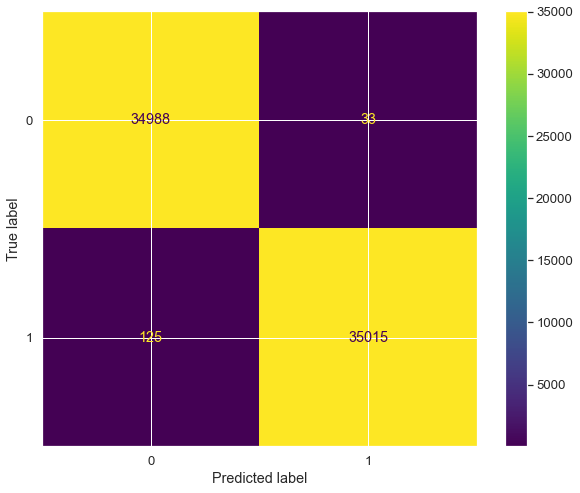



Confusion matrix for the test set
[[6883 1926]
 [1947 6785]]


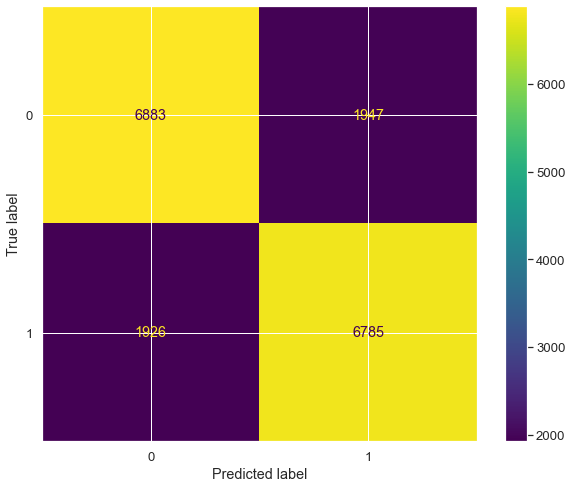

In [220]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df_best = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                                         precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})

display(performance_df_best)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train2,y_TF_train_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_train2, y_TF_train2, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test2,y_TF_test_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_test2,y_TF_test2, values_format = 'd')
plt.show()

### >>> With bigrams only

In [200]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [201]:
X_TF_down_bi = tidf.fit_transform(df_down['review'])
y_TF_down_bi = df_down['rating']

#### Train test split

In [202]:
X_TF_down_bi_train, X_TF_down_bi_test, y_TF_down_bi_train, y_TF_down_bi_test = train_test_split(X_TF_down_bi, y_TF_down_bi, test_size=0.20, random_state=42)

In [203]:
type(X_TF_down_bi_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [204]:
rf4 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_down_bi_train = y_TF_down_bi_train.astype('int')
y_TF_down_bi_test  = y_TF_down_bi_test.astype('int')

rf4.fit(X_TF_down_bi_train, y_TF_down_bi_train)

y_TF_down_bi_train_pred_rf = rf4.predict(X_TF_down_bi_train)
y_TF_down_bi_test_pred_rf  = rf4.predict(X_TF_down_bi_test)

#### Model performance

In [205]:
model_performance_class(y_TF_down_bi_train, y_TF_down_bi_train_pred_rf, y_TF_down_bi_test, 
                        y_TF_down_bi_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     35021
           1       0.97      0.84      0.90     35140

    accuracy                           0.91     70161
   macro avg       0.91      0.91      0.91     70161
weighted avg       0.91      0.91      0.91     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.44
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8830
           1       0.75      0.65      0.70      8711

    accuracy                           0.72     17541
   macro avg       0.72      0.72      0.72     17541
weighted avg       0.72      0.72      0.72     17541



#### Tuning the hyper paramters with gridsearch

In [206]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [207]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [208]:
grid_search.fit(X_TF_train2,y_TF_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [150, 200],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100]},
             return_train_score=True)

In [209]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 200,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [210]:
#pd.DataFrame(grid_search.cv_results_)

In [211]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.6063055266985586


In [212]:
metrics.RocCurveDisplay

sklearn.metrics._plot.roc_curve.RocCurveDisplay

In [213]:
metrics.RocCurveDisplay.from_estimator

<bound method RocCurveDisplay.from_estimator of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

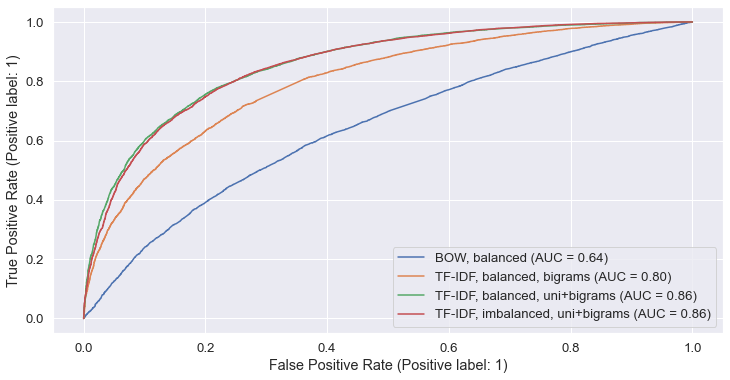

In [214]:
# 1 - BOW, down
disp = plot_roc_curve(rf2, X_test2, y_test2, name="BOW, balanced")
plt.gcf().set_size_inches(12,6)
#2 - TF-IDF down bi grams
plot_roc_curve(rf4, X_TF_down_bi_test, y_TF_down_bi_test, name="TF-IDF, balanced, bigrams", ax=disp.ax_);

#3 - TF-IDF down uni/bi grams
plot_roc_curve(rf3, X_TF_test2, y_TF_test2, name="TF-IDF, balanced, uni+bigrams", ax=disp.ax_);

#4 - TF-IDF full uni/bi grams
plot_roc_curve(rf1, X_TF_test, y_TF_test, name="TF-IDF, imbalanced, uni+bigrams", ax=disp.ax_);

In [215]:
# Plot recall (chose green option as recall for cat 1 is better)

In [216]:
performance_df1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                #         precision_score(y_TF_train, y_TF_train_pred_rf),
                                 #        recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})
performance_df_best1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                               #          precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                #         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})


In [217]:
performance_df1

,Error_metric,Test
0,Accuracy,0.784127
1,Precision,0.775191
2,Recall,0.948700


In [218]:
performance_df_best1

,Error_metric,Test
0,Accuracy,0.779203
1,Precision,0.777027
2,Recall,0.778900
